Dataset: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=rating.csv

## Librerias

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from dataprep.eda import create_report
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

## Recolección de la data.

In [2]:
ratings = pd.read_csv("rating.csv")
items = pd.read_csv("anime.csv")

## Preparación de la data/ preprocesamiento la data

In [3]:
ratings.head(6)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1


In [4]:
items.head(6)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351


In [5]:
items_titles = items[["anime_id", "name"]]
items_titles.head(6)

,anime_id,name
0,32281,Kimi no Na wa.
1,5114,Fullmetal Alchemist: Brotherhood
2,28977,Gintama°
3,9253,Steins;Gate
4,9969,Gintama&#039;
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...


In [6]:
items_ratings = ratings.merge(items_titles, on="anime_id")
items_ratings.head(6)

,user_id,anime_id,rating,name
0,1,20,-1,Naruto
1,3,20,8,Naruto
2,5,20,6,Naruto
3,6,20,-1,Naruto
4,10,20,-1,Naruto
5,21,20,8,Naruto


In [7]:
items_ratings.rename(columns={'anime_id': 'item_id'}, inplace = True)

In [8]:
items_titles[items_titles["name"] == "Naruto"]

,anime_id,name
841,20,Naruto


In [9]:
items_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813727 entries, 0 to 7813726
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  int64 
 1   item_id  int64 
 2   rating   int64 
 3   name     object
dtypes: int64(3), object(1)
memory usage: 298.1+ MB


In [10]:
items_ratings.isna().any()

user_id    False
item_id    False
rating     False
name       False
dtype: bool

In [11]:
items_ratings.loc[items_ratings['rating'] == -1, 'rating'] = 0

In [12]:
items_ratings = items_ratings.sample(16000)

## Análisis descriptivo de la data (EDA)

In [13]:
report = create_report(items_ratings)
report.save("Reporte")

  0%|          | 0/694 [00:00<?, ?it/s]

c:\Users\Addison\Documents\GitHub\Anime-System-Recomendations\venv\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\Addison\Documents\GitHub\Anime-System-Recomendations\venv\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))


Report has been saved to Reporte.html!


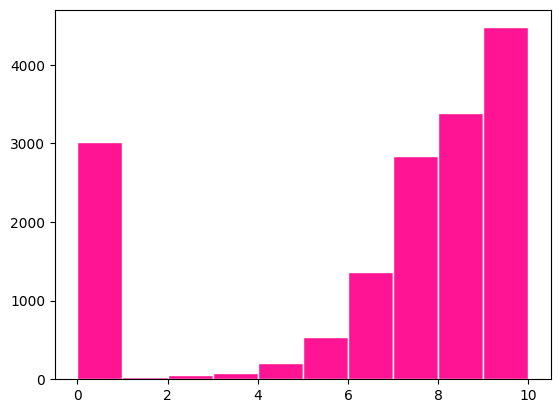

In [14]:
plt.hist(items_ratings['rating'], color="deeppink", edgecolor="white")
plt.show()

## Entrenamiento del modelo.

In [15]:
encoder = LabelEncoder()

In [16]:
encoder.fit(items_ratings['user_id'])
items_ratings.loc[:, 'user_id'] = sorted(encoder.transform(items_ratings['user_id']))

encoder.fit(items_ratings['item_id'])
items_ratings.loc[:, 'item_id'] = encoder.transform(items_ratings['item_id'])

In [17]:
df_train, df_val = train_test_split(items_ratings, test_size=0.2, random_state=42)

In [18]:
n_users = len(items_ratings.user_id.unique())
n_items = len(items_ratings.item_id.unique())

train_matrix = np.zeros((n_users, n_items))

for row in df_train.itertuples():
    train_matrix[row[1]-1, row[2]-1] = row[3]

In [19]:
input_users = tf.keras.layers.Input(shape=[1])
embedding_users = tf.keras.layers.Embedding(n_users, 100)(input_users)
flatten_users = tf.keras.layers.Flatten()(embedding_users)

input_items = tf.keras.layers.Input(shape=[1])
embedding_items = tf.keras.layers.Embedding(n_items, 100)(input_items)
flatten_items = tf.keras.layers.Flatten()(embedding_items)

In [20]:
concat = tf.keras.layers.Concatenate()([flatten_users, flatten_items])

dense1 = tf.keras.layers.Dense(128, activation='relu')(concat)
dropout1 = tf.keras.layers.Dropout(0.2)(dense1)

dense2 = tf.keras.layers.Dense(64, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.2)(dense2)

In [21]:
output = tf.keras.layers.Dense(1)(dropout2)

model = tf.keras.Model(inputs=[input_users, input_items], outputs=output)
model.compile(loss='mse', optimizer='adam')

In [22]:
model.fit([df_train.user_id, df_train.item_id], df_train.rating, epochs=10, verbose=1, validation_split=0.2, batch_size=70)

Epoch 1/10
147/147 [==============================] - 4s 20ms/step - loss: 21.7819 - val_loss: 11.4454
Epoch 2/10
147/147 [==============================] - 3s 19ms/step - loss: 8.1379 - val_loss: 13.4078
Epoch 3/10
147/147 [==============================] - 3s 19ms/step - loss: 4.6127 - val_loss: 14.2016
Epoch 4/10
147/147 [==============================] - 3s 20ms/step - loss: 3.3701 - val_loss: 14.6783
Epoch 5/10
147/147 [==============================] - 3s 20ms/step - loss: 2.6754 - val_loss: 14.8529
Epoch 6/10
147/147 [==============================] - 3s 19ms/step - loss: 2.3020 - val_loss: 14.9138
Epoch 7/10
147/147 [==============================] - 3s 20ms/step - loss: 1.9535 - val_loss: 15.5340
Epoch 8/10
147/147 [==============================] - 3s 19ms/step - loss: 1.7690 - val_loss: 15.5821
Epoch 9/10
147/147 [==============================] - 3s 19ms/step - loss: 1.5781 - val_loss: 16.0712
Epoch 10/10
147/147 [==============================] - 3s 20ms/step - loss: 1.466

In [23]:
model.fit([df_train.user_id, df_train.item_id], df_train.rating, epochs=10, verbose=1, validation_split=0.2, batch_size=70)

Epoch 1/10
147/147 [==============================] - 3s 20ms/step - loss: 1.3191 - val_loss: 15.9600
Epoch 2/10
147/147 [==============================] - 3s 19ms/step - loss: 1.2652 - val_loss: 16.2438
Epoch 3/10
147/147 [==============================] - 3s 19ms/step - loss: 1.1932 - val_loss: 16.0938
Epoch 4/10
147/147 [==============================] - 3s 20ms/step - loss: 1.1779 - val_loss: 16.4240
Epoch 5/10
147/147 [==============================] - 3s 19ms/step - loss: 1.0970 - val_loss: 16.5616
Epoch 6/10
147/147 [==============================] - 3s 19ms/step - loss: 1.0281 - val_loss: 16.4369
Epoch 7/10
147/147 [==============================] - 3s 19ms/step - loss: 1.0148 - val_loss: 16.2770
Epoch 8/10
147/147 [==============================] - 3s 20ms/step - loss: 1.0075 - val_loss: 16.0722
Epoch 9/10
147/147 [==============================] - 3s 19ms/step - loss: 0.9658 - val_loss: 16.1666
Epoch 10/10
147/147 [==============================] - 3s 19ms/step - loss: 0.9090

In [24]:
model.fit([df_train.user_id, df_train.item_id], df_train.rating, epochs=10, verbose=1, validation_split=0.2, batch_size=70)

Epoch 1/10
147/147 [==============================] - 3s 20ms/step - loss: 0.9447 - val_loss: 16.2858
Epoch 2/10
147/147 [==============================] - 3s 20ms/step - loss: 0.8780 - val_loss: 16.0329
Epoch 3/10
147/147 [==============================] - 3s 19ms/step - loss: 0.8570 - val_loss: 16.2854
Epoch 4/10
147/147 [==============================] - 3s 19ms/step - loss: 0.8409 - val_loss: 16.2366
Epoch 5/10
147/147 [==============================] - 3s 19ms/step - loss: 0.7739 - val_loss: 16.4258
Epoch 6/10
147/147 [==============================] - 3s 19ms/step - loss: 0.7588 - val_loss: 16.3668
Epoch 7/10
147/147 [==============================] - 3s 19ms/step - loss: 0.7595 - val_loss: 16.1507
Epoch 8/10
147/147 [==============================] - 3s 20ms/step - loss: 0.7210 - val_loss: 16.1696
Epoch 9/10
147/147 [==============================] - 3s 19ms/step - loss: 0.7022 - val_loss: 16.1474
Epoch 10/10
147/147 [==============================] - 3s 19ms/step - loss: 0.6905

In [25]:
test_loss = model.evaluate([df_val.user_id, df_val.item_id], df_val.rating)
print('Test loss:', test_loss)

100/100 [==============================] - 0s 1ms/step - loss: 15.7229
Test loss: 15.722870826721191


In [26]:
def recommend_items(user_id, model, n=2):
    #Se obtiene items que ya ha visto el usuario
    seen_movies = items_ratings[items_ratings['user_id'] == user_id]['item_id'].tolist()
    
    #Se obtiene items que el usuario aún no ha visto
    item_ids = list(set(items_ratings['item_id']) - set(seen_movies))
    
    #Se predicen las puntuaciones para las items no vistas
    ratings_pred = model.predict([np.array([user_id]*len(item_ids)), np.array(item_ids)])
    ratings_pred = np.array([rating[0] for rating in ratings_pred])
    
    #Obtener los mejores n items recomendadas
    top_item_ids = (-ratings_pred).argsort()[:n]
    top_item_ids = [item_ids[i] for i in top_item_ids]
    top_item_ids += [0]*(n - len(top_item_ids))
    top_ratings_pred = ratings_pred[top_item_ids]

    #Se crea un DataFrame con los mejores n items
    items_pred = pd.DataFrame(columns=['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'])

    i = 0
    for ids in top_item_ids:
        items_pred.loc[i] = items.iloc[ids]
        i += 1

    items_pred['predicted_rating'] = top_ratings_pred
    
    return items_pred

## Recomendaciones

In [27]:
user_id = 16
recommendations = recommend_items(user_id, model, n=3)
recommendations

104/104 [==============================] - 0s 1ms/step


,anime_id,name,genre,type,episodes,rating,members,predicted_rating
0,6324,Omamori Himari,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.19,119572,-0.018156
1,4186,Chrome Shelled Regios,"Action, Adventure, Fantasy, School, Sci-Fi",TV,24,7.57,103615,6.951766
2,1434,Lupin III: Harimao no Zaihou wo Oe!!,"Action, Adventure, Comedy, Shounen",Special,1,7.16,3057,0.009716


In [28]:
user_id = 69
recommendations = recommend_items(user_id, model, n=3)
recommendations

104/104 [==============================] - 0s 1ms/step


,anime_id,name,genre,type,episodes,rating,members,predicted_rating
0,6024,Chi&#039;s Sweet Home: Atarashii Ouchi,"Comedy, Kids, Slice of Life",TV,104,7.9,16670,9.494140
1,6324,Omamori Himari,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.19,119572,6.650553
2,3483,Maison Ikkoku: Utsuriyuku Kisetsu no Naka de,"Comedy, Drama, Romance",OVA,1,7.15,1458,3.755569
